
# Estimation of the Hurst function of a multifractional Brownian motion

.. codeauthor:: Frédéric Richard <frederic.richard_at_univ-amu.fr>

The multifractional Brownian motion is a random process whose regularity
varies in time. For this process, this regularity is determined by a
functional parameter called the Hurst function. This function maps time
position into the interval (0, 1). The larger the value, the smoother
the process at a position. In this example, we use varprox
to estimate the Hurst function.

To define the objective function, we use a least square criterion which
compares the local quadratic variations of an observed process to
the theoretical ones of a multifractional Brownian motion. We use a TV
regularization to stabilize the estimation and evaluate its effect.

<div class="alert alert-info"><h4>Note</h4><p>This example requires the installation of the
    [PyAFBF](https://github.com/fjprichard/PyAFBF)_.</p></div>


Optimization without regularization:
varprox reg = None   | iter    0 / 1000: cost = 4.871723e+01 improved by 2.7187 percent.
varprox reg = None   | iter    1 / 1000: cost = 4.772748e+01 improved by 2.0316 percent.
varprox reg = None   | iter    2 / 1000: cost = 4.699879e+01 improved by 1.5268 percent.
varprox reg = None   | iter    3 / 1000: cost = 4.645678e+01 improved by 1.1532 percent.
varprox reg = None   | iter    4 / 1000: cost = 4.605011e+01 improved by 0.8754 percent.
varprox reg = None   | iter    5 / 1000: cost = 4.574272e+01 improved by 0.6675 percent.
varprox reg = None   | iter    6 / 1000: cost = 4.550898e+01 improved by 0.5110 percent.
varprox reg = None   | iter    7 / 1000: cost = 4.533013e+01 improved by 0.3930 percent.
varprox reg = None   | iter    8 / 1000: cost = 4.519261e+01 improved by 0.3034 percent.
varprox reg = None   | iter    9 / 1000: cost = 4.508640e+01 improved by 0.2350 percent.
varprox reg = None   | iter   10 / 1000: cost = 4.500405e+01 improved by 

varprox reg = None   | iter   27 / 1000: cost = 4.470859e+01 improved by 0.0036 percent.
varprox reg = None   | iter   28 / 1000: cost = 4.470729e+01 improved by 0.0029 percent.
varprox reg = None   | iter   29 / 1000: cost = 4.470624e+01 improved by 0.0023 percent.
varprox reg = None   | iter   30 / 1000: cost = 4.470539e+01 improved by 0.0019 percent.
varprox reg = None   | iter   31 / 1000: cost = 4.470470e+01 improved by 0.0015 percent.
varprox reg = None   | iter   32 / 1000: cost = 4.470414e+01 improved by 0.0013 percent.
varprox reg = None   | iter   33 / 1000: cost = 4.470368e+01 improved by 0.0010 percent.
varprox reg = None   | iter   34 / 1000: cost = 4.470331e+01 improved by 0.0008 percent.
Optimization with TV regularization:
varprox reg = tv-1d  | iter    0 / 1000: cost = 4.991315e+01 improved by 0.3308 percent.
varprox reg = tv-1d  | iter    1 / 1000: cost = 4.976913e+01 improved by 0.2885 percent.
varprox reg = tv-1d  | iter    2 / 1000: cost = 4.962954e+01 improved by 

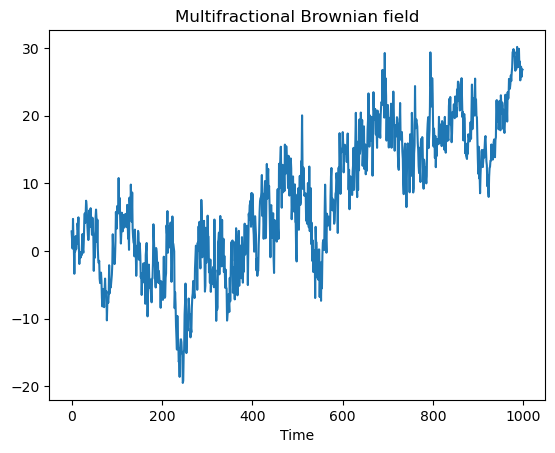

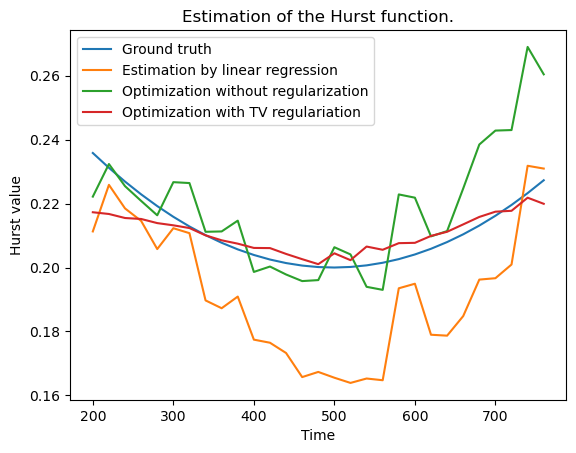

In [1]:
from afbf import process
from numpy.random import default_rng, seed
from numpy import zeros, std, arange, power, mean, maximum, minimum, log, array
from numpy import concatenate, ones, inf
from scipy.optimize import lsq_linear
from varprox import Minimize, Parameters
from varprox.models.model_mfbm import Ffun, DFfun
from matplotlib import pyplot as plt


def Simulate_MFBM(H, seed_n=1):
    """Simulate the multi-fractional Brownian motion of Hurst function H.

    :param ndarray H: The hurst function of the process.
    :type H: :ref:`ndarray`

    :param seed_n: A seed number.
    :type seed_n: int.

    :returns: a simulation of the process.
    """
    N = H.size

    fbm = process()
    y = zeros((N,))
    if min(H) != max(H):
        # Simulation of a multifractional Brownian motion.
        for j in range(N):
            seed(seed_n)
            fbm.param = H[j]
            fbm.Simulate(N)
            y[j] = 10 * fbm.y[j, 0] / std(fbm.y)
    else:
        # Simulation of a fractional Brownian motion.
        seed(seed_n)
        fbm.param = H[0]
        fbm.Simulate(N)
        y = fbm.y

    return y


def Estimate_LocalSemiVariograms(y, scales, w_size, w_step, order=0):
    """Compute the local semi-variogram of the process.

    :param y: A process
    :type H: :ref:`ndarray`
    :param scales: Scales at which the semi-variogram is to be computed.
    :type H: :ref:`ndarray`
    :param w_size: Size of the window where the semi-variogram is computed.
    :type w_size: int
    :param w_step: Step between two successive positions of computations.
    :type w_step: int
    :param order: Order of the increments. The default is 0.
    :type order: int

    :returns: Semi-variograms at each position (row) and scale (column).
    """

    N = y.size
    order += 1
    Nr = N - order * max(scales) - w_size

    if Nr < 0:
        raise Exception("Decrease max of scales or w_size.")

    v = zeros((Nr // w_step + 1, scales.size))
    for j in range(scales.size):
        # Increments
        scale = scales[j]
        increm = zeros(y.shape)
        increm[:] = y[:]
        for o in range(order):
            increm = increm[:-scale] - increm[scale:]
        increm = power(increm[:-scale] - increm[scale:], 2)
        # Local semi-variogram.
        w_ind = 0
        for w in range(0, Nr, w_step):
            v[w_ind, j] = 0.5 * mean(increm[w:w + w_size])
            w_ind += 1

    return v


def Estimate_HurstFunction(scales, v):
    """Estimate the Hurst function using linear regressions.

    :param scales: Scales at which the semi-variogram was computed.
    :type H: :ref:`ndarray`
    :param v: Empirical semi-variogram.
    :type v: :ref:`ndarray`

    :return: Variance factors, Hurst function.
    :rtype: :ref:`ndarray`

    """
    N = v.shape[0]  # Number of positions.
    P = v.shape[1]  # Number of scales.
    v = log(maximum(v, 1e-310))
    scales = 2 * log(scales).reshape((P, 1))
    X = concatenate((scales, ones((P, 1))), axis=1)
    lb = array([0, - inf])
    ub = array([1, inf])

    H = zeros((N,))
    c = zeros((N,))
    for j in range(N):
        # Estimate the Hurst index at the nth position.
        pb = lsq_linear(X, v[j, :], bounds=(lb, ub))
        H[j] = pb.x[0]
        c[j] = pb.x[1]

    return H, c


rng = default_rng()
seed(15)

# Experiment parameters
N = 1000  # Size of the observed process.
order = 1  # Order of the quadratic variations to analyze the process.
scales = array([1, 5, 10])  # scales at which analyze the process.
w_size = 400  # Size of the local window where the process is analyzed.
w_step = 20  # Displacement step of the window.
H1 = 0.2  # Minimal Hurst value.
H2 = 0.3  # Maximal Hurst value.
mfbm = True  # Set to True for experiment on multifractional Brownian field.

#: 1. Simulation.
#: Create the Hurst function.
if mfbm:
    T = arange(stop=N, step=2)
    N = N - 1
    T = power(T / N, 2)
    H = (1 - T) * H1 + T * H2
    H = concatenate((H[::-1], H[1:]))
else:
    H = 0.3 * ones(H.shape)
#: Simulate a mfbm of Hurst function H.
seed_n = 1
y = Simulate_MFBM(H, seed_n)
# Estimate the local semi-variogram of y.
v = Estimate_LocalSemiVariograms(y, scales, w_size, w_step, order)

#: 2. Estimations.
#: 2.1. Estimate the Hurst function by linear regression.
Hest1, c1 = Estimate_HurstFunction(scales, v)

#: 2.2. Estimate the Hurst function by minimisation without regularization.
scales2 = power(scales, 2)
logscales = log(scales2)
w = v.reshape((v.size,), order="F")

Hest2 = ones(Hest1.shape)
Hest2[:] = Hest1[:]
Hest2 = minimum(maximum(0.0001, Hest2), 0.9999)
pb = Minimize(Hest2, w, Ffun, DFfun, scales2, logscales, 0)
param = Parameters()
param.load("plot_mfbm.ini")
param.reg.name = None
pb.params = param
print("Optimization without regularization:")
Hest2, c2 = pb.argmin_h()
h2value = pb.h_value()


#: 2.3. Estimate of the Hurst function by minimisation with a regularization.
#: Regularization parameter x.
Hest3 = ones(Hest2.shape)
Hest3[:] = Hest1[:]
Hest3 = minimum(maximum(0.0001, Hest3), 0.9999)
pb = Minimize(Hest3, w, Ffun, DFfun, scales2, logscales, 0)
param.load("./plot_mfbm.ini")
param.reg.name = 'tv-1d'
pb.params = param
print("Optimization with TV regularization:")
Hest3, c3 = pb.argmin_h()

#: 3. Plot results.
plt.figure(1)
w_size2 = w_size // 2
plt.plot(y)
plt.title("Multifractional Brownian field")
plt.xlabel('Time')
plt.show()

plt.figure(2)
w_size2 = w_size // 2
t = arange(H.size)
t = t[w_size2:-w_size2:w_step]
t = t[0:Hest1.size]
Htrue = H[w_size2:-w_size2:w_step]
Htrue = Htrue[0:Hest1.size]
plt.plot(t, Htrue, label="Ground truth")
plt.plot(t, Hest1, label="Estimation by linear regression")
plt.plot(t, Hest2, label="Optimization without regularization")
plt.plot(t, Hest3, label="Optimization with TV regulariation")
plt.title("Estimation of the Hurst function.")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Hurst value')
plt.show()